In [55]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import optuna

seed = 211
np.random.seed(seed)

<ipython-input-55-88461a3b10a8>:9: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [56]:
filepath = 'input/NASDAQ_DAYLY.csv'
#d_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%d')
nasdaq = pd.read_csv(filepath)
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], format = '%Y-%m-%d')
#data = data.sort_values('Date')
nasdaq = nasdaq.set_index('Date')
#nasdaq = nasdaq.sort_values(by='Date',ascending=False)
nasdaq = nasdaq[['Close']]
nasdaq

,Close
Date,
2002-12-18,1013.669983
2002-12-19,1006.049988
2002-12-20,1013.900024
2002-12-23,1032.300049
2002-12-24,1023.289978
...,...
2021-06-07,13802.889648
2021-06-08,13810.860352
2021-06-09,13814.940430


In [57]:
filepath = 'input/WALCL.csv'
#d_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%d')
assets = pd.read_csv(filepath)
assets['DATE'] = pd.to_datetime(assets['DATE'], format = '%Y-%m-%d')
#data = data.sort_values('Date')
assets = assets.rename(columns={'DATE':'Date',"WALCL":'Millions_of_Dollars'})
assets.set_index('Date',inplace=True)
nasdaq['Assets'] = assets['Millions_of_Dollars']
nasdaq = nasdaq.dropna()
del nasdaq['Assets']

scaler1 = MinMaxScaler(feature_range=(0.1, 1))
scaled = nasdaq.copy()
scaled['Close'] = scaler1.fit_transform(scaled['Close'].values.reshape(-1,1))
scaled

,Close
Date,
2002-12-18,0.103946
2003-01-08,0.105946
2003-01-15,0.108102
2003-01-22,0.103449
2003-01-29,0.104146
...,...
2021-05-12,0.935264
2021-05-19,0.951649
2021-05-26,0.983883


In [58]:
nasdaq

,Close
Date,
2002-12-18,1013.669983
2003-01-08,1042.520020
2003-01-15,1073.599976
2003-01-22,1006.510010
2003-01-29,1016.559998
...,...
2021-05-12,13001.629883
2021-05-19,13237.910156
2021-05-26,13702.740234


In [59]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back, use_perm = True):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back + 1): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    rand_perm = np.random.permutation(data.shape[0])
    if use_perm: 
        data = data[rand_perm,:,:]
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    y_train = y_train[:,0].reshape(-1,1)
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    y_test = y_test[:,0].reshape(-1,1)
    
    return [x_train, y_train, x_test, y_test], rand_perm
[x_train, y_train, x_test, y_test], rand_perm = load_data(scaled, 50, use_perm=False)
print(scaler1.inverse_transform(y_test)[-5:])

[[13001.629883]
 [13237.910156]
 [13702.740234]
 [13675.790039]
 [13814.94043 ]]


In [60]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

# Prediction with GRU

In [61]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def objective(trial):
    look_back = trial.suggest_int("Look Back",5,100) # choose sequence length
    [x_train, y_train, x_test, y_test], _ = load_data(scaled, look_back, use_perm=True)
    x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
    
    input_dim = 1
    hidden_dim = trial.suggest_int("Hidden Dim",16,128,log=True)
    num_layers = trial.suggest_int("N layers",1,5)
    output_dim = 1
    model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

    loss_fn = torch.nn.MSELoss()
    lr = trial.suggest_float("Learning Rate",1e-4,1,log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    num_epochs = 1000
    factor = trial.suggest_float('Factor',0.1,1,log=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=5)
    for epoch in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred = model(x_train)

        loss = loss_fn(y_train_pred, y_train)

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        scheduler.step(loss)
        trial.report(loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return loss

In [62]:
# now we can run the experiment
sampler = optuna.samplers.TPESampler()
study_gru = optuna.create_study(study_name="GRU", direction="minimize", sampler=sampler)
study_gru.optimize(objective, n_trials=100, timeout=120*60)

pruned_trials = [t for t in study_gru.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study_gru.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study_gru.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

[I 2021-06-21 16:53:15,028] A new study created in memory with name: GRU
[I 2021-06-21 16:53:26,400] Trial 0 finished with value: 0.0005971321952529252 and parameters: {'Look Back': 8, 'Hidden Dim': 16, 'N layers': 4, 'Learning Rate': 0.003475689931597431, 'Factor': 0.1909797773732862}. Best is trial 0 with value: 0.0005971321952529252.
[I 2021-06-21 16:53:47,785] Trial 1 finished with value: 0.04929756745696068 and parameters: {'Look Back': 58, 'Hidden Dim': 22, 'N layers': 4, 'Learning Rate': 0.6168673910804733, 'Factor': 0.7027669939958612}. Best is trial 0 with value: 0.0005971321952529252.
[I 2021-06-21 16:54:26,741] Trial 2 finished with value: 8.281258583068848 and parameters: {'Look Back': 95, 'Hidden Dim': 55, 'N layers': 2, 'Learning Rate': 0.2448923228361607, 'Factor': 0.10720387150541116}. Best is trial 0 with value: 0.0005971321952529252.
[I 2021-06-21 16:54:46,884] Trial 3 finished with value: 0.0005238065496087074 and parameters: {'Look Back': 18, 'Hidden Dim': 46, 'N la

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  90
  Number of complete trials:  10


In [63]:
optuna.visualization.plot_param_importances(study_gru)

In [64]:
print("Best trial:")
trial_gru = study_gru.best_trial

print("Value: ", trial_gru.value)
print(trial_gru.params)

Best trial:
Value:  9.850820788415149e-05
{'Look Back': 34, 'Hidden Dim': 23, 'N layers': 2, 'Learning Rate': 0.025597580420296567, 'Factor': 0.16728904466534308}


In [65]:
look_back = trial_gru.params['Look Back'] # choose sequence length
[x_train, y_train, x_test, y_test], rand_perm = load_data(scaled, look_back, use_perm=True)
print('x_train.shape = ',x_train.shape)
#print('y_train.shape = ',y_train.shape)
#print('x_test.shape = ',x_test.shape)
#print('y_test.shape = ',y_test.shape)
# make training and test sets in torch
#print(device)
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

x_train.shape =  (738, 33, 1)


In [66]:
input_dim = 1
hidden_dim = trial_gru.params['Hidden Dim']
num_layers = trial_gru.params['N layers']
output_dim = 1
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss()
lr = trial_gru.params['Learning Rate']
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
"""
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
print(list(model.parameters())[i].size())
"""
num_epochs = 1000
factor = trial_gru.params['Factor']
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience = 5)
hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if epoch % 50 == 0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()
    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    scheduler.step(loss)

Epoch  0 MSE:  0.3597719073295593
Epoch  50 MSE:  0.0003337089729029685
Epoch  100 MSE:  0.00026028562569990754
Epoch  150 MSE:  0.00022811155940871686
Epoch  200 MSE:  0.0001984529080800712
Epoch  250 MSE:  0.00017385157116223127
Epoch  300 MSE:  0.00015451194485649467
Epoch  350 MSE:  0.00013981231313664466
Epoch  400 MSE:  0.00012891505321022123
Epoch  450 MSE:  0.00012095746933482587
Epoch  500 MSE:  0.00011516302038216963
Epoch  550 MSE:  0.00011089360486948863
Epoch  600 MSE:  0.00010766302875708789
Epoch  650 MSE:  0.0001051239887601696
Epoch  700 MSE:  0.00010304144234396517
Epoch  750 MSE:  0.00010126308188773692
Epoch  800 MSE:  9.96919916360639e-05
Epoch  850 MSE:  9.826720634009689e-05
Epoch  900 MSE:  9.695028711576015e-05
Epoch  950 MSE:  9.571696136845276e-05


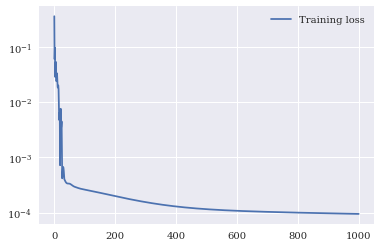

In [67]:
plt.semilogy(hist, label="Training loss")
plt.legend()
plt.show()

In [68]:
# make predictions
y_test_pred = model(x_test)
# invert predictions

y_train_pred = scaler1.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scaler1.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler1.inverse_transform(y_test.cpu().detach().numpy())


In [69]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
#ShiftedtestScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
#print('Shifted Test Score: %.2f RMSE' % (ShiftedtestScore))

Train Score: 140.24 RMSE
Test Score: 149.66 RMSE


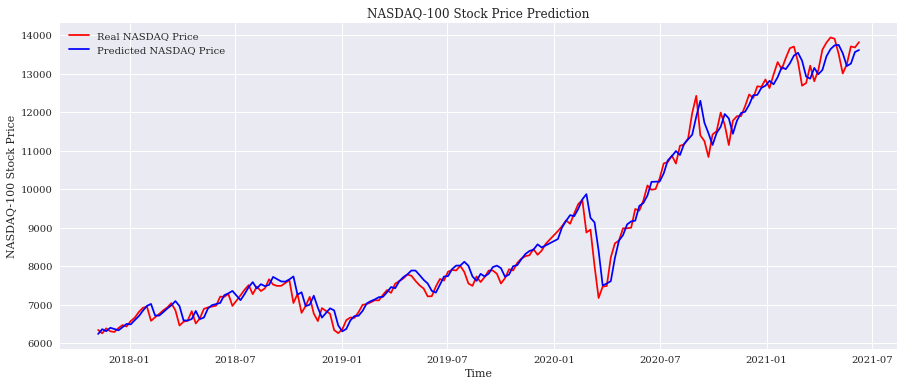

In [70]:
[_, _, x_test, y_test], rand_perm = load_data(scaled, look_back, use_perm = False)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
#y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
y_test_pred = model(x_test)
y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler1.inverse_transform(y_test)
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test, color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted NASDAQ Price')
#axes.xticks(np.arange(0,394,50))
plt.title('NASDAQ-100 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NASDAQ-100 Stock Price')
plt.legend()

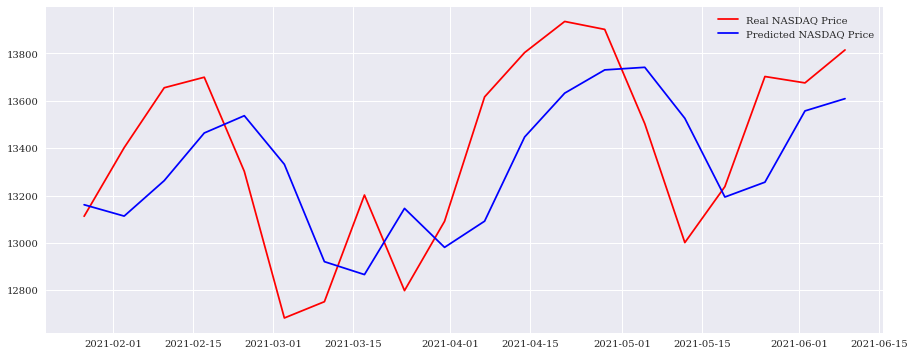

In [71]:
last = 20
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[-last:].index, y_test[-last:], color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[-last:].index, y_test_pred[-last:], color = 'blue', label = 'Predicted NASDAQ Price')
plt.legend()

[13675.326171875, 13625.7939453125, 13588.0615234375, 13566.3916015625, 13552.41796875]


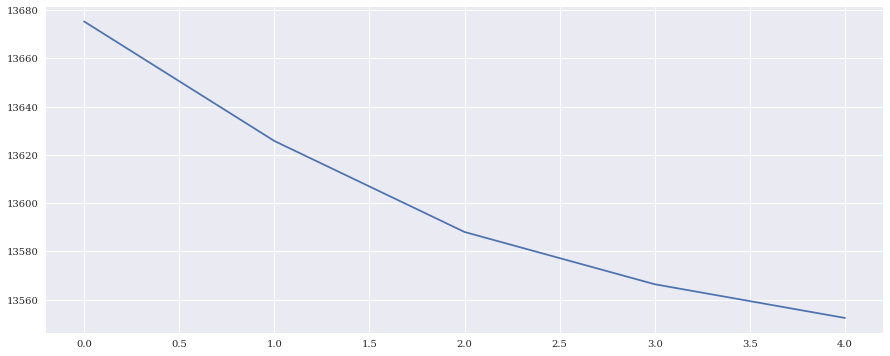

In [72]:
data_raw = scaled.values
predictions = []
n = 5
data = np.array(data_raw[len(data_raw) - look_back:])
x_test = data.reshape(1,data.shape[0],data.shape[1])
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
for _ in range(n):
    y_test_pred = model(x_test)
    tmp = torch.tensor([[[y_test_pred[0,0].item()]]]).to(device)
    #x_test = np.concatenate((data_raw,tmp),axis=0,dtype='object')
    x_test = torch.cat((x_test,tmp),1)[:,1:,:]
    ##print(x_test.shape)
    y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
    predictions.append(y_test_pred.item())
#print(predictions)
figure, axes = plt.subplots(figsize=(15, 6))
print(predictions)
axes.plot(predictions)
#next_week_forecast = model(data)

# Prediction with LSTM

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def objective(trial):
    look_back = trial.suggest_int("Look Back",5,100) # choose sequence length
    [x_train, y_train, x_test, y_test], _ = load_data(scaled, look_back, use_perm=True)
    x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
    
    input_dim = 1
    hidden_dim = trial.suggest_int("Hidden Dim",16,128,log=True)
    num_layers = trial.suggest_int("N layers",1,3)
    output_dim = 1
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

    loss_fn = torch.nn.MSELoss()
    lr = trial.suggest_float("Learning Rate",1e-4,1,log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    num_epochs = 1000
    factor = trial.suggest_float('Factor',0.1,1,log=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=5)
    for epoch in range(num_epochs):
        # Initialise hidden state
        # Don't do this if you want your LSTM to be stateful
        #model.hidden = model.init_hidden()

        # Forward pass
        y_train_pred = model(x_train)

        loss = loss_fn(y_train_pred, y_train)

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()
        scheduler.step(loss)
        trial.report(loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return loss

In [74]:
# now we can run the experiment
sampler = optuna.samplers.TPESampler()
study_lstm = optuna.create_study(study_name="LSTM", direction="minimize", sampler=sampler)
study_lstm.optimize(objective, n_trials=100, timeout=120*60)

pruned_trials = [t for t in study_lstm.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study_lstm.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("  Number of finished trials: ", len(study_lstm.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
#print("  Params: ")
#for key, value in trial.params.items():
#    print("    {}: {}".format(key, value))

[I 2021-06-21 16:56:21,409] A new study created in memory with name: LSTM
[I 2021-06-21 16:56:32,632] Trial 0 finished with value: 0.0034124362282454967 and parameters: {'Look Back': 37, 'Hidden Dim': 20, 'N layers': 3, 'Learning Rate': 0.0002833027007843885, 'Factor': 0.2795629355662403}. Best is trial 0 with value: 0.0034124362282454967.
[I 2021-06-21 16:56:37,933] Trial 1 finished with value: 0.00017522306006867439 and parameters: {'Look Back': 17, 'Hidden Dim': 17, 'N layers': 2, 'Learning Rate': 0.019796422497708875, 'Factor': 0.27459754150885407}. Best is trial 1 with value: 0.00017522306006867439.
[I 2021-06-21 16:57:09,082] Trial 2 finished with value: 0.08784137666225433 and parameters: {'Look Back': 87, 'Hidden Dim': 43, 'N layers': 2, 'Learning Rate': 0.47407835065963805, 'Factor': 0.5000551988934265}. Best is trial 1 with value: 0.00017522306006867439.
[I 2021-06-21 16:57:19,278] Trial 3 finished with value: 0.00029170585912652314 and parameters: {'Look Back': 56, 'Hidden D

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  90
  Number of complete trials:  10


In [75]:
optuna.visualization.plot_param_importances(study_lstm)

In [76]:
print("Best trial:")
trial_lstm = study_lstm.best_trial

print("Value: ", trial_lstm.value)
print(trial_lstm.params)

Best trial:
Value:  9.17450015549548e-05
{'Look Back': 24, 'Hidden Dim': 44, 'N layers': 2, 'Learning Rate': 0.004145397061336217, 'Factor': 0.9934804627309587}


In [87]:
look_back = trial_lstm.params['Look Back'] # choose sequence length
[x_train, y_train, x_test, y_test], rand_perm = load_data(scaled, look_back, use_perm=True)
#print('x_train.shape = ',x_train.shape)
#print('y_train.shape = ',y_train.shape)
#print('x_test.shape = ',x_test.shape)
#print('y_test.shape = ',y_test.shape)
# make training and test sets in torch
#print(device)
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

In [88]:
input_dim = 1
hidden_dim = trial_lstm.params['Hidden Dim']
num_layers = trial_lstm.params['N layers']
output_dim = 1
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)

loss_fn = torch.nn.MSELoss()
lr = trial_lstm.params['Learning Rate']
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
"""
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
print(list(model.parameters())[i].size())
"""
num_epochs = 1000
factor = trial_lstm.params['Factor']
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience = 5)
hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if epoch % 50 == 0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()
    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    scheduler.step(loss)

Epoch  0 MSE:  0.2451074868440628
Epoch  50 MSE:  0.0016677927924320102
Epoch  100 MSE:  0.0003019296273123473
Epoch  150 MSE:  0.0002541027497500181
Epoch  200 MSE:  0.0002293667639605701
Epoch  250 MSE:  0.000214020095882006
Epoch  300 MSE:  0.0002033571945503354
Epoch  350 MSE:  0.00019517779583111405
Epoch  400 MSE:  0.0001883683871710673
Epoch  450 MSE:  0.00018232448201160878
Epoch  500 MSE:  0.0001767082285368815
Epoch  550 MSE:  0.0001713410601951182
Epoch  600 MSE:  0.0001661512505961582
Epoch  650 MSE:  0.00016113201854750514
Epoch  700 MSE:  0.00015629878907930106
Epoch  750 MSE:  0.00015165528748184443
Epoch  800 MSE:  0.00014718722377438098
Epoch  850 MSE:  0.00014287419617176056
Epoch  900 MSE:  0.00013870070688426495
Epoch  950 MSE:  0.00013466250675264746


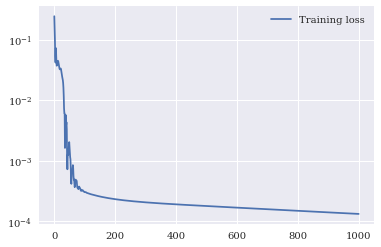

In [89]:
plt.semilogy(hist, label="Training loss")
plt.legend()
plt.show()

In [90]:
# make predictions
y_test_pred = model(x_test)
# invert predictions

y_train_pred = scaler1.inverse_transform(y_train_pred.cpu().detach().numpy())
y_train = scaler1.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler1.inverse_transform(y_test.cpu().detach().numpy())


In [91]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
#ShiftedtestScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
#print('Shifted Test Score: %.2f RMSE' % (ShiftedtestScore))

Train Score: 164.95 RMSE
Test Score: 183.11 RMSE


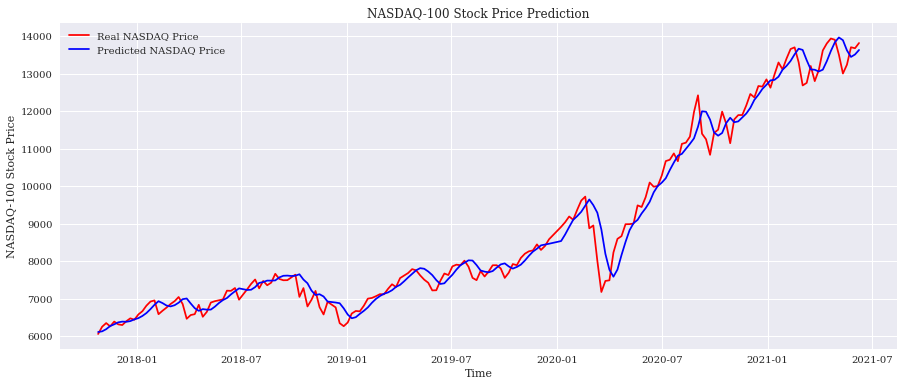

In [92]:
[_, _, x_test, y_test], rand_perm = load_data(scaled, look_back, use_perm = False)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
#y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
y_test_pred = model(x_test)
y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
y_test = scaler1.inverse_transform(y_test)
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test, color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted NASDAQ Price')
#axes.xticks(np.arange(0,394,50))
plt.title('NASDAQ-100 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NASDAQ-100 Stock Price')
plt.legend()

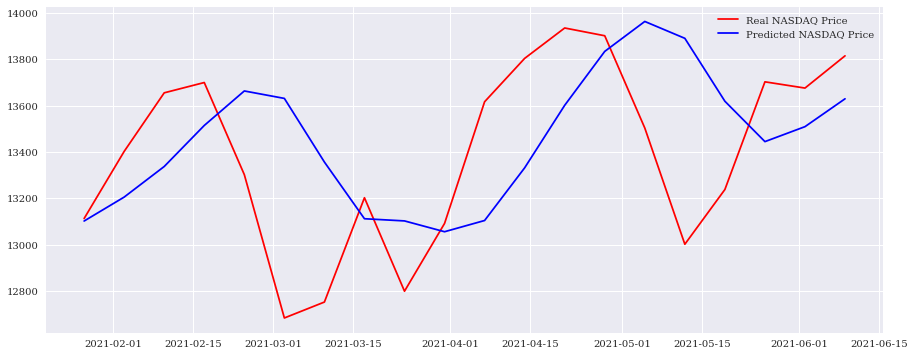

In [93]:
last = 20
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(nasdaq[-last:].index, y_test[-last:], color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[-last:].index, y_test_pred[-last:], color = 'blue', label = 'Predicted NASDAQ Price')
plt.legend()

[13773.130859375, 13861.029296875, 13926.56640625, 13982.19921875, 14033.6162109375]


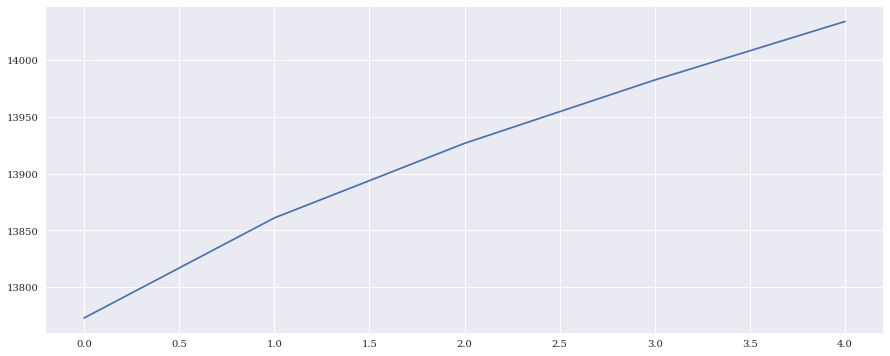

In [94]:
data_raw = scaled.values
predictions = []
n = 5
data = np.array(data_raw[len(data_raw) - look_back:])
x_test = data.reshape(1,data.shape[0],data.shape[1])
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
for _ in range(n):
    y_test_pred = model(x_test)
    tmp = torch.tensor([[[y_test_pred[0,0].item()]]]).to(device)
    #x_test = np.concatenate((data_raw,tmp),axis=0,dtype='object')
    x_test = torch.cat((x_test,tmp),1)[:,1:,:]
    ##print(x_test.shape)
    y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
    predictions.append(y_test_pred.item())
#print(predictions)
figure, axes = plt.subplots(figsize=(15, 6))
print(predictions)
axes.plot(predictions)
#next_week_forecast = model(data)